# Assignment 2:
## Lev Svalov, B18-DS-02
In this assignment, you are going to solve three problems: 

1. Improving Nearest Neighbors Retrieval Speed (8 points)
2. Gaussian Naive Bayes (4 points)
3. PCA (3 points)

## 1. Improving Nearest Neighbors Retrieval Speed (8 points)

You are given a dataset of coordinates and information about places around the globe. Explore the dataset. You will be mostly working with 2d vectors which represent longitude and latitude.

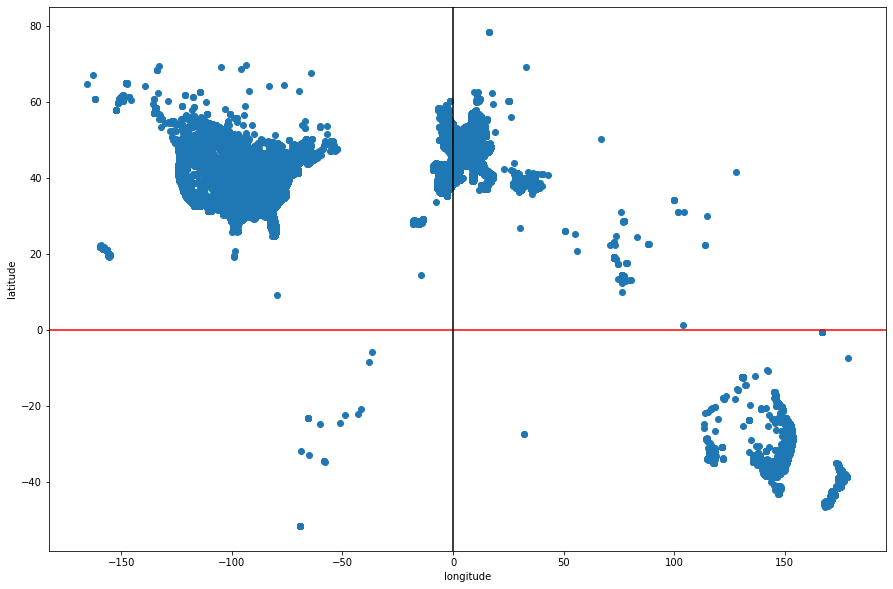

In [26]:
import pickle

import matplotlib.pyplot as plt

with open("/Users/levsvalov/code_workspace/Fall2020/ML/Assignment2/poi_sample001.pickle", "rb") as f:
    dataset = pickle.load(f)
    
X = [v[0][0] for v in dataset]
Y = [v[0][1] for v in dataset]

plt.figure(figsize=(15, 10))
a = plt.axes()
a.set_xlabel('longitude')
a.set_ylabel('latitude')
plt.axhline(0, color='red')
plt.axvline(0, color='black')
plt.scatter(X, Y)
plt.show()

### 1.1 Simple NN Search

Implement the simplest form of NN search (exhaustive search).
Your function should: 
1. Calculate the distance between the test point and each dataset point using euclidean distance.
2. Sort the dataset according to calculated distance in ascending order.
3. Return the top K points from the sorted dataset.

You need to implement this from scratch. Don't use library solutions. 
It is okay to use library function for eucliden distance.

In [27]:
from scipy.spatial import distance

def simple_nns(v, data, k):
    """
    param: v: test point
    param: data: dataset
    param: k: number of nearest neighbors to retrive
    return: list of nearest points from the dataset
    """
    # implement simple NN Search
    distances = []
    neighbors = []
    for data_point in data:
        d = distance.euclidean(v, data_point[0])
        distances.append(( data_point,d))
    distances.sort(key=lambda x: x[1])
    for i in range(k):
        neighbors.append(distances[i][0])
    return neighbors


Find the first 100 nearest neighbors of Paris. However, we are only interested in shops. Filter out everything that doesn't contain 'Shop' substring in the description and plot the remaining points.

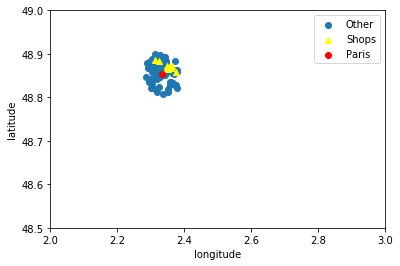

In [28]:
paris = [2.334083, 48.853260]

# find and plot the nearest neighbors according to the above instructions

paris_nn = simple_nns(paris, dataset, 100)
x_shops  = []
y_shops = []
x_other = []
y_other = []
for data in paris_nn:
    if 'Shop' in data[1]:
        x_shops.append(data[0][0])
        y_shops.append(data[0][1])
    else:
        x_other.append(data[0][0])
        y_other.append(data[0][1])

a = plt.axes()
a.set_xlabel('longitude')
a.set_ylabel('latitude')
plt.scatter(x_other,y_other, label="Other")
plt.scatter(x_shops,y_shops,label="Shops", marker='^',c='yellow')
plt.scatter(paris[0],paris[1],label="Paris",c='red')
plt.legend(loc="best")

# axes limits are set for better visualization, don't change them
plt.ylim(48.5, 49)
plt.xlim(2,3)
plt.show()

Measure retrieval time of `simple_nns` for every given number of nearest neighbors. Every time select some random point from the dataset. Plot the results.

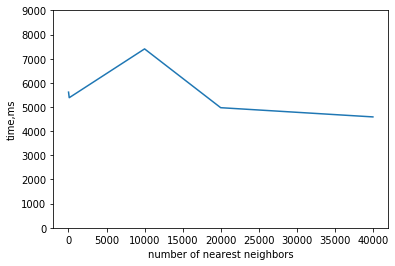

In [29]:
from random import choice
from time import time
# numbers of nearest neghbors to retrieve
nns = [10, 100, 1000, 10000, 20000, 40000]
time_simple_nns = []


# measure retrival time for every value above and save it somewhere 
for n in nns:
    start = time()
    neighbours = simple_nns(choice(dataset)[0],dataset,n)
    end = time()
    time_simple_nns.append(1000*(end-start))

# plot the results
plt.ylim(0,9000)
plt.plot(nns, time_simple_nns, label="The simplest")
plt.xlabel("number of nearest neighbors")
plt.ylabel("time,ms")
plt.show()

What do you observe? Do you see any trends, how can you explain them?

<span style="color:blue"> Your answer:</span>
<br>
We can see that the simplest implementation of the nearest neighbour algorithm requires approximately equal amount of time per differrent number of the required nearest neighboours. Therefore, the total range between times is quite small.
Nevertheless, there is hardly observed trend that time-function has some specific form.
It looks similiar to  either linearly increasing form, or constant for most of the attempts, but we can't not say the exact form since from time to time we can obtain considerably different graphs (with peaks or lows in the middle).
<br>
So that, the graph has a strange behaviour and it is also related to the fact that the point we are choosing for getting neighbours is different for every step
and it is chosen randomly.
<br>
But we consider the graph from the broader perspective (like in 1.3 in comparison of 2 solutions),
we will see that it will look like almost constant form function.


### 1.2 Improving NNS

Choose any method you like to speed up NN search, understand it thoroughly and learn how to apply it. Explain the way it works in few sentences and in your own words.

<span style="color:blue"> Your answer: </span>
<br>
I have chose the ANNOY method and the idea behind it is in the folowing:
<br>
ANNOY is tree-based algorithm that constructs collection of trees as their data structure by splitting
the dataset into subsets. The key concept is in trees with the fact that any query can be done in O(logN) time-complexity.
So, it builds a collection of trees for fast access to dataset in order to get the nearest neigbours.
<br>
Ok, that's pretty much clear. Next, how it constructs these trees?
<br>
For every tree, there are 2 randomly chosen points that divide the space into 2 hyperplanes,
and this process of picking 2 points and splitting into smaller subspaces again recursevely repeats until we reach to the satisfactory size of the subtree(s).
So that, the biggest tree is constructed (basically tree of smaller trees, and soon). It is called forest of the trees,
and we manually tune the number of trees in the forest before the indexing the dataset.
<br>
When we want to find the vector, we traverse the tree.
<br>
And, similiarly, when we want to find K-nearest neighbours, we traverse the tree in order to find the instances with the closest distance to the given one.

Apply the chosen method on the geographic dataset. Similarly to the above, find the nearest neighbors and plot retrieval times.

In [30]:
# apply the chosen method
from annoy import AnnoyIndex

f = 2
t = AnnoyIndex(f, 'euclidean')
for i in range(len(dataset)):
    t.add_item(i,dataset[i][0])
n_trees = 5
t.build(n_trees)

def nn_with_annoy(v, data, k):
    return t.get_nns_by_vector(v,k,search_k=-1, include_distances=False)

Find the first 100 nearest neighbors of Paris. However, we are only interested in shops. Filter out everything that doesn't contain 'Shop' substring in the description and plot the remaining points.

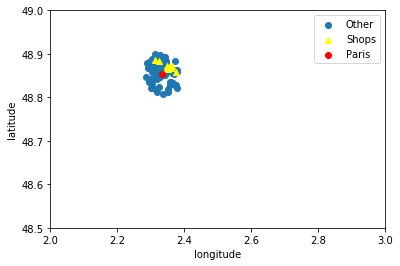

In [31]:
paris = [2.334083, 48.853260]

# find and plot the nearest neighbors according to the above instructions
paris_nn = nn_with_annoy(paris,dataset,100)

x_shops  = []
y_shops = []
x_other = []
y_other = []
for id in paris_nn:
    if 'Shop' in dataset[id][1]:
        x_shops.append(dataset[id][0][0])
        y_shops.append(dataset[id][0][1])
    else:
        x_other.append(dataset[id][0][0])
        y_other.append(dataset[id][0][1])

a = plt.axes()
a.set_xlabel('longitude')
a.set_ylabel('latitude')
plt.scatter(x_other,y_other, label="Other")
plt.scatter(x_shops,y_shops,label="Shops",marker='^',c='yellow')
plt.scatter(paris[0],paris[1],label="Paris",c='red')
plt.legend(loc="best")


# axes limits are set for better visualization, don't change them
plt.ylim(48.5, 49)
plt.xlim(2,3)
plt.show()

Measure retrieval time of `simple_nns` for every given number of nearest neighbors. Every time select some random point from the dataset. Plot the results.

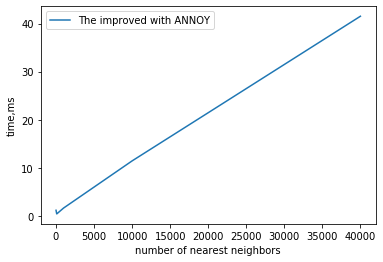

In [32]:
from random import choice
from time import time
# numbers of nearest neghbors to retrieve
nns = [10, 100, 1000, 10000, 20000, 40000]
time_improved_nns = []

# measure retrival time for every value above and save it somewhere
for n in nns:
    start = time()
    neighbours = nn_with_annoy(choice(dataset)[0],dataset,n)
    end = time()
    time_improved_nns.append(1000*(end-start))

# plot the result
plt.plot(nns, time_improved_nns, label="The improved with ANNOY")
plt.xlabel("number of nearest neighbors")
plt.ylabel("time,ms")
plt.legend(loc="best")
plt.show()

What do you observe? Do you see any trends, how can you explain them?

<span style="color:blue"> Your answer: </span>
<br>
From the graph, we can observe the following trends:
<br>
First, the graph has linearly increasing form, with bigger  n - number of nearest neighbours to find, the time also becomes bigger.
<br>
Second, it is much faster than the straight implementation of the nearest neighbour algorithm.

### 1.3 Comparison

Plot retrieval times together in the same plot. If time difference is big (as it should be), use a logarithmic scale for better visualization. If you don't achieve any time improvements, then you are doing something wrong.

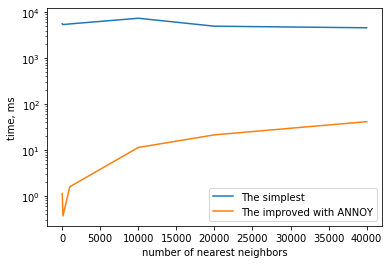

In [33]:
# plot retrieval times together
plt.yscale('log')
plt.plot(nns, time_simple_nns, label="The simplest")
plt.plot(nns, time_improved_nns, label="The improved with ANNOY")
plt.xlabel("number of nearest neighbors")
plt.ylabel("time, ms")
plt.legend(loc="best")
plt.show()

Analyze the results and summarise them here. 

<span style="color:blue"> Your answer: </span>
<br>
From the result graph with 2 approaches of implementation of the nearest neighboours algorithm: Simplest and Improved with ANNOY method,
we can observe that approaches differ significantly in terms of time: theImproved method with ANNOY is much faster than
simple implementation, to be more specific, in 100 times on average.

## 2. Gaussian Naive Bayes (4 points)

Finish the implementation of Gaussian NB.

In [34]:
from math import sqrt, exp, pi
import pandas as pd
import numpy as np
def pdf(x, mean, std):
	exponent = exp(-((x-mean)**2 / (2 * std**2 )))
	return (1 / (sqrt(2 * pi) * std)) * exponent

class GaussianNB:

    def fit(self, X_train, y_train):
        """
        fit classifier, i.e. calculate needed statistics
        """
        ### START CODE HERE ###
        X_train = pd.DataFrame(X_train)
        self.prior = X_train.groupby(y_train).apply(lambda x: len(x))/X_train.shape[0]
        self.means = X_train.groupby(y_train).apply(np.mean)
        self.std = X_train.groupby(y_train).apply(np.std)
        ### END CODE HERE ###
        
    def predict(self, X_test):
        """
        predict class labels for test data points
        param: test_data: list of data points to be classified
        return: predictions (class labels)
        """
        ### START CODE HERE ###
        y_pred = []
        X_test =  pd.DataFrame(X_test)
        for idx_test_value in range(X_test.shape[0]):
            probs = {}
            for cl in np.unique(y_train):
                probs[cl] = self.prior.iloc[cl]
                index = 0
                for x in X_test.iloc[idx_test_value]:
                    mean = self.means.iloc[cl,index]
                    std = self.std.iloc[cl,index]
                    probs[cl] *= pdf(x,mean,std)
                    index += 1
            prediction = pd.Series(probs).values.argmax()
            y_pred.append(prediction)
        ### END CODE HERE ###
        return y_pred

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris
iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.2, random_state=0)


gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

# You should get the accuracy score not less than 90%.
print(accuracy_score(y_test, y_pred))

0.9666666666666667


The implementation of Gaussian Naive Bayes classifier gives accuracy more than 96%

## 3. PCA

Apply PCA to the Digits dataset, produce the scree plot for the given data and decide the optimal number of PCs to keep. Calculate and print their total explained variance.

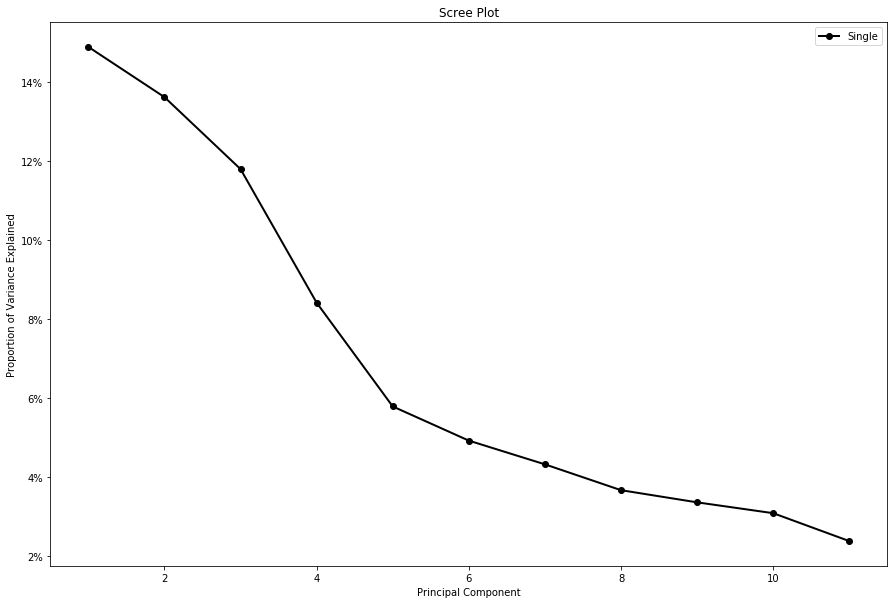

59.108522305707


In [36]:
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
import numpy as np
X, y = load_digits(return_X_y=True)

# apply PCA
pca = PCA(n_components=11)
pca.fit(X,y)

# make scree plot
PC_values = np.arange(pca.n_components) + 1
plt.figure(figsize=(15, 10))
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2,color='black', label="Single")
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) # for percentages in y-axis
plt.legend(loc="best")
plt.show()

# choose the number PCs and calculate and print their total explained variance
print(pca.explained_variance_[5])


Thoroughly justify your choice - this is the main part of the work for this task
<br>
<span style="color:blue"> Your answer: </span> <br>
I think the optimal number of component is 5 because:
<br>
Adding next components does not give us such significant values in terms of explained variance as first 5 components did.
And if we will check the cumulative graph with all components together(see below), it proves that after 5th component, it grows in more smooth way.
<br>
<br>
It means that it is arguable to add next components:
<br>
From one point of view, they will give the bigger number of total variability:
  as we can see, if we stop on 5th component, we will have approximately 55%, but till the end, 11th component - more than 70%.
<br>
Nevertheless, we can see that further diminishing does not worth it, in comparison the growth in first 5 components.
 <br>
 <br>
  That is why, I suppose that the optimal amount of components for this example is 5.

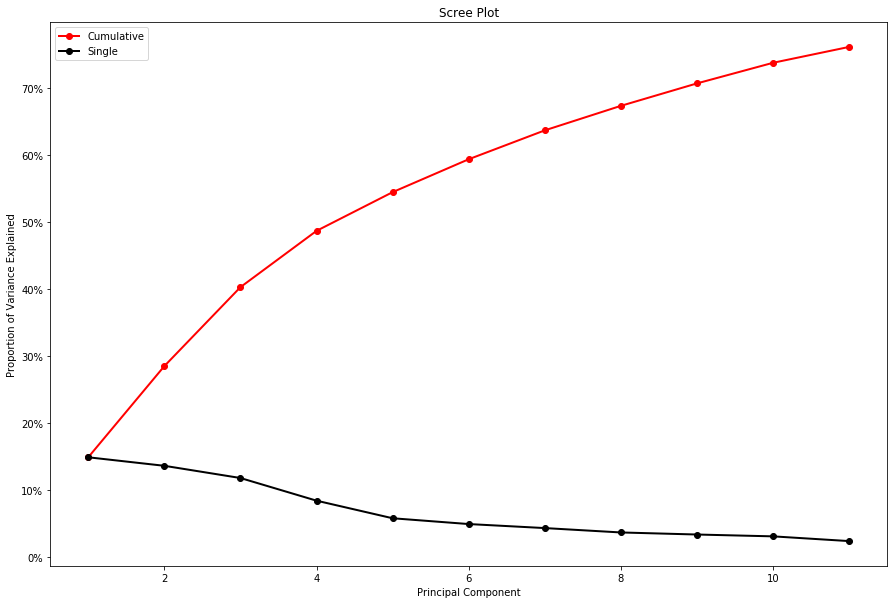

In [37]:
cumulative = [pca.explained_variance_ratio_[0]]
for i in range(1,len(PC_values)):
    cumulative.append(cumulative[i-1]+pca.explained_variance_ratio_[i])
plt.figure(figsize=(15, 10))
plt.plot(PC_values, cumulative, 'ro-', linewidth=2,color='red', label="Cumulative")
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2,color='black', label="Single")
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) # for percentages in y-axis
plt.legend(loc="best")
plt.show()